In [1]:
import math
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
from scipy.integrate import quad, trapz

import scipy.stats
import scipy.optimize
from scipy.signal import find_peaks

%pylab inline

from lmfit import minimize, Parameters, Model, fit_report

Populating the interactive namespace from numpy and matplotlib


/home/almaz/miniconda3/envs/science/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['trapz']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
print(sc.__version__)

1.6.2


In [3]:
enrichment = 0.959
total_GT = 48
total_IAS = 16

Exp_beam_en = 420 #MeV
Q_EC_100Tc = 0.172
S_p_100Tc = 7.3398 #MeV

R_square = 7.98

bin_3_35 = 0.152
bin_35_4 = 0.223

In [4]:
def gauss(x, mu, sigma, k):
    return k*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))

def gauss2(x, mu, sigma, k):
    return (k / sigma)*np.exp((-1/2)*((x - mu)/sigma)**2) 

def line(x, a, b):
    return a*x+b

def breit_vigner2(x, M, w = 11.3, alpha = 0.018):
    G = alpha * (w ** 2) + 1
    #G = alpha * (w ** 2)
    y = M * (G**1) * (1-np.exp(-(x/G)**2) ) / ((x - w)**2 + (G**2)/1)
    return np.round(y, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов

def breit_vigner3(x, M, w,  G1):
    G = G1
    y = M * (G**1) * (1-np.exp(-(x/G)**2) ) / ((x - w)**2 + (G**2)/1)
    return np.round(y, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов

def breit_vigner4(x, M, w,  G1):
    a = M/(2*np.pi*G1)
    b = 1 + np.square(2*(x-w)/G1)
    return np.round(a/b, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов

In [5]:
def QFC_back4(x, E_qf, N_0, Q_EC=Q_EC_100Tc, E_beam=Exp_beam_en, S_p=S_p_100Tc):
    W = 22
    T = 100
    #Q_EC_76As=0.9233
    #S_p_76As=7.723
    #E_t_gs = 420 - Q_EC_76As
    #E_0 = E_t_gs - S_p_76As
    E_t_gs = E_beam - Q_EC
    E_0 = E_t_gs - S_p
    
    E = E_t_gs - x
    
    values = N_0 * ( 1 - np.exp((E-E_0)/T) )/( 1 + ((E-E_qf)/W)**2)
    values_more0 = values[ np.where(values>0) ]
    beginning = np.zeros((len(x)-len(values_more0)))
    return np.concatenate((beginning, values_more0))

In [6]:
data_to_fit_x = np.linspace(0,30, 4000)

### red

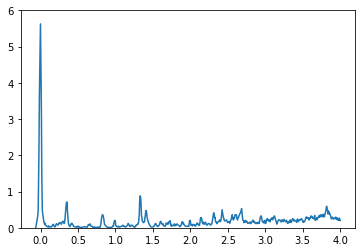

In [7]:
red_0_4 = pd.read_csv('../B(GT) peaks processing/recognition/Mo100/0/0-4.csv', 
                      sep=';', decimal=',', names=['x', 'y'])
plt.plot(red_0_4['x'].values, red_0_4['y'].values)
plt.ylim(0,6)
plt.show()
#red_0_4.head()

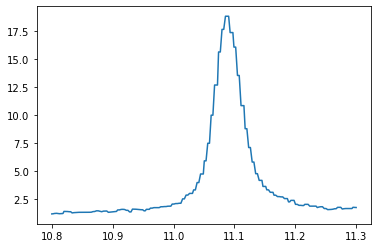

In [8]:
redIAS = pd.read_csv('../B(GT) peaks processing/recognition/Mo100/0/IAS.csv', 
                      sep=';', decimal=',', names=['x', 'y'])
plt.plot(redIAS['x'].values, redIAS['y'].values)
#plt.ylim(0,6)
plt.show()

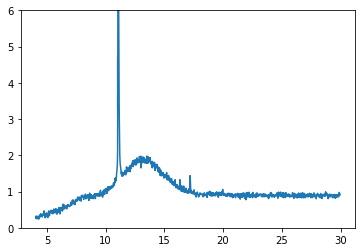

In [9]:
red_4_30 = pd.read_csv('../B(GT) peaks processing/recognition/Mo100/0/4-30.csv', 
                      sep=';', decimal=',', names=['x', 'y'])
plt.plot(red_4_30['x'].values, red_4_30['y'].values)
plt.ylim(0,6)
plt.show()

In [10]:
def prepare_data(x_data_out, dataframe0_4, dataframeIAS, dataframe4_28, noIAS=False, distance=60):
    beginning = dataframe4_28[((dataframe4_28['x']<10.85))]
    middle = dataframeIAS[((dataframeIAS['x']>10.85) & (dataframeIAS['x']<11.25))]
    ending = dataframe4_28[((dataframe4_28['x']>11.25))]
#        beginning = dataframe4_28[((dataframe4_28['x']<10.85))]
    
    x04_data = np.linspace(0,4,len(dataframe0_4['x'].values))
    y04_data = np.interp(x04_data, dataframe0_4['x'].values, dataframe0_4['y'].values)
    
    peaks, _ = sc.signal.find_peaks(-y04_data+30, distance=distance)
    
    #y_data2 doesn't contain IAS
    y04_data = np.interp(x04_data, x04_data[peaks], y04_data[peaks])
    
    temp2 = pd.DataFrame({'x':x04_data, 'y':y04_data})
    
    #data3 - smothed data with IAS
    data3 = temp2.append(beginning).append(middle).append(ending)
    
    if noIAS == True: data3 = temp2.append(dataframe4_28)
    
    y_data_out = np.interp(x_data_out, data3['x'].values, data3['y'].values)
    
    data_full = dataframe0_4.append(beginning).append(middle).append(ending)
#    data_full = pd.DataFrame({'x':x_data_out, 
#                              'y':np.interp(x_data_out, data_full['x'].values, data_full['y'].values)})
    return data_full, y_data_out

def prepare_data_noIAS(x_data_out, dataframe0_4, dataframeIAS, dataframe4_28, distance=60):
    beginning = dataframe4_28[((dataframe4_28['x']<10.65))]
    ending = dataframe4_28[((dataframe4_28['x']>11.55))]
#        beginning = dataframe4_28[((dataframe4_28['x']<10.85))]
    
    x04_data = np.linspace(0,4,len(dataframe0_4['x'].values))
    y04_data = np.interp(x04_data, dataframe0_4['x'].values, dataframe0_4['y'].values)
    
    peaks, _ = sc.signal.find_peaks(-y04_data+30, distance=distance)
    
    #y_data2 doesn't contain IAS
    y04_data = np.interp(x04_data, x04_data[peaks], y04_data[peaks])
    
    temp2 = pd.DataFrame({'x':x04_data, 'y':y04_data})
    
    #data3 - smothed data with IAS
    data3 = temp2.append(beginning).append(ending)
    
    y_data_out = np.interp(x_data_out, data3['x'].values, data3['y'].values)
    
    data_full = dataframe0_4.append(beginning).append(ending)
#    data_full = pd.DataFrame({'x':x_data_out, 
#                              'y':np.interp(x_data_out, data_full['x'].values, data_full['y'].values)})
    return data_full, y_data_out


(0.0, 10.0)

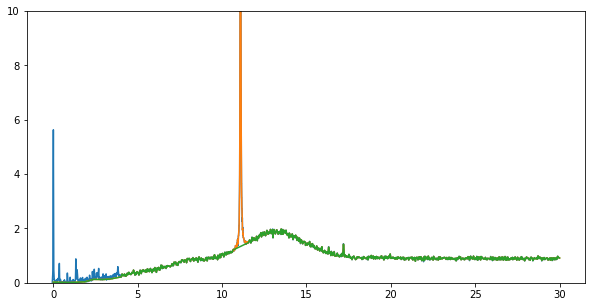

In [11]:
red_full, red_smothed = prepare_data(data_to_fit_x, red_0_4, redIAS, red_4_30)
red_full_noIAS, red_smothed_noIAS = prepare_data_noIAS(data_to_fit_x, red_0_4, redIAS, red_4_30)

plt.figure(figsize=(10,5))
plt.plot(red_full['x'].values, red_full['y'].values)
plt.plot(data_to_fit_x, red_smothed)
plt.plot(data_to_fit_x, red_smothed_noIAS)
#plt.xlim(10,15)
plt.ylim(0,10)

(0.0, 5.0)

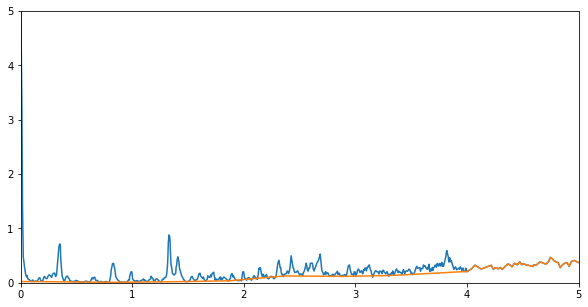

In [12]:
plt.figure(figsize=(10,5))
plt.plot(red_full['x'].values, red_full['y'].values)
plt.plot(data_to_fit_x, red_smothed)
plt.xlim(0,5)
plt.ylim(0,5)

(10.0, 12.0)

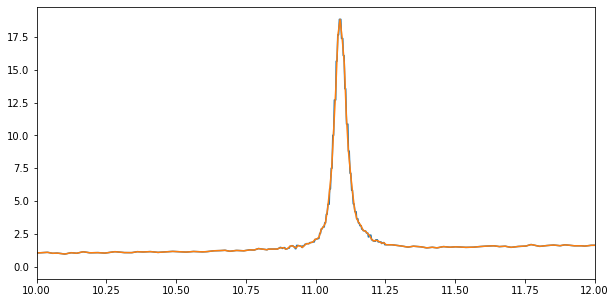

In [13]:
plt.figure(figsize=(10,5))
plt.plot(red_full['x'].values, red_full['y'].values)
plt.plot(data_to_fit_x, red_smothed)
plt.xlim(10,12)
#plt.ylim(0,5)

### yellow

In [14]:
yellow_0_4 = pd.read_csv('../B(GT) peaks processing/recognition/Mo100/1/0-4.csv', 
                      sep=';', decimal=',', names=['x','y'],)
yellowIAS = pd.read_csv('../B(GT) peaks processing/recognition/Mo100/1/IAS.csv', 
                      sep=';', decimal=',', names=['x','y'], )
yellow_4_28 = pd.read_csv('../B(GT) peaks processing/recognition/Mo100/1/4-30.csv', 
                      sep=';', decimal=',', names=['x','y'],)

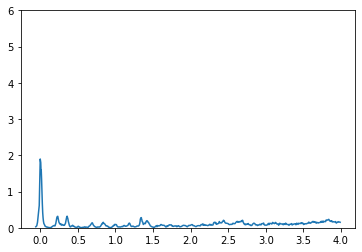

In [15]:
plt.plot(yellow_0_4['x'].values, yellow_0_4['y'].values)
plt.ylim(0,6)
plt.show()

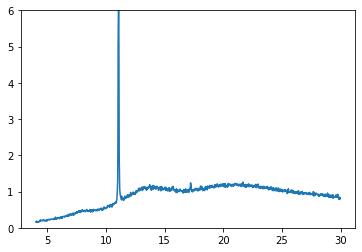

In [16]:
plt.plot(yellow_4_28['x'].values, yellow_4_28['y'].values)
plt.ylim(0,6)
plt.show()

(0.0, 10.0)

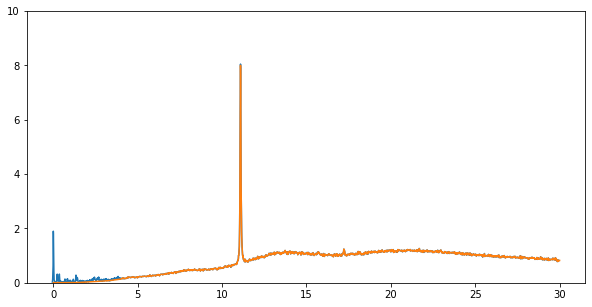

In [17]:
yellow_full, yellow_smothed = prepare_data(data_to_fit_x, yellow_0_4, yellowIAS, yellow_4_28)

plt.figure(figsize=(10,5))
plt.plot(yellow_full['x'].values, yellow_full['y'].values)
plt.plot(data_to_fit_x, yellow_smothed)
#plt.xlim(0,10)
plt.ylim(0,10)

### violet

(0.0, 5.0)

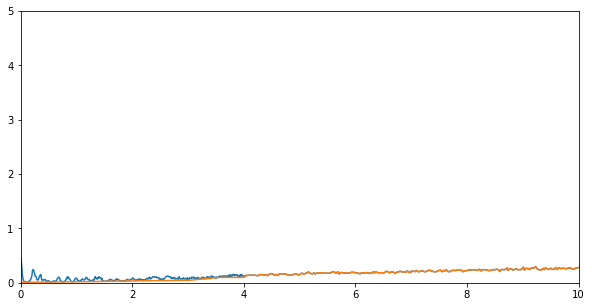

In [18]:
violet_0_4 = pd.read_csv('../B(GT) peaks processing/recognition/Mo100/2/0-4.csv', 
                         sep=';', decimal=',', names=['x','y'], header=None)
violet_4_28 = pd.read_csv('../B(GT) peaks processing/recognition/Mo100/2/4-30.csv', 
                         sep=';', decimal=',', names=['x','y'], header=None)

violet_full, violet_smothed = prepare_data(data_to_fit_x, violet_0_4, violet_4_28, 
                                           violet_4_28, noIAS=True)

plt.figure(figsize=(10,5))
plt.plot(violet_full['x'].values, violet_full['y'].values)
plt.plot(data_to_fit_x, violet_smothed)
plt.xlim(0,10)
plt.ylim(0,5)

(0.0, 5.0)

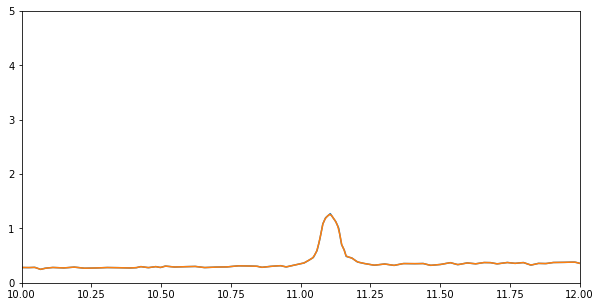

In [19]:
plt.figure(figsize=(10,5))
plt.plot(violet_full['x'].values, violet_full['y'].values)
plt.plot(data_to_fit_x, violet_smothed)
plt.xlim(10,12)
plt.ylim(0,5)

https://stackoverflow.com/questions/20339234/python-and-lmfit-how-to-fit-multiple-datasets-with-shared-parameters

https://groups.google.com/forum/#!topic/lmfit-py/orAT3mJJdL4

In [20]:

#data_to_fit_y = np.array([red_smothed, violet_smothed])
data_to_fit_y = red_smothed.reshape((1,4000))
data_to_fit_y_noIAS = red_smothed_noIAS.reshape((1,4000))

data_to_fit_x.shape, data_to_fit_y.shape

((4000,), (1, 4000))

In [21]:
def total_dataset(params, i, x):
    """calc data from params for data set i
    using simple, hardwired naming convention"""
    
    PR1_w = params['PR1_w_%i' % (i+1)].value
    PR1_G1 = params['PR1_G1_%i' % (i+1)].value
    PR1_M = params['PR1_M_%i' % (i+1)].value
    
#    IAS1_w = params['IAS1_w_%i' % (i+1)].value
#    IAS1_G1 = params['IAS1_G1_%i' % (i+1)].value
#    IAS1_M = params['IAS1_M_%i' % (i+1)].value
        
    GTR_w = params['GTR_w_%i' % (i+1)].value
    GTR_G1 = params['GTR_G1_%i' % (i+1)].value
    GTR_M = params['GTR_M_%i' % (i+1)].value

    SDR_w = params['SDR_w_%i' % (i+1)].value
    SDR_G1 = params['SDR_G1_%i' % (i+1)].value
    SDR_M = params['SDR_M_%i' % (i+1)].value
    
    QFC_Eqf = params['QFC_Eqf_%i' % (i+1)].value
    QFC_N0 = params['QFC_N0_%i' % (i+1)].value
    
#    out = breit_vigner3(x, PR1_M, PR1_w, PR1_G1)\
#    + breit_vigner3(x, IAS1_M, IAS1_w, IAS1_G1)\
#    + breit_vigner3(x, GTR_M, GTR_w, GTR_G1)\
#    + breit_vigner3(x, SDR_M, SDR_w, SDR_G1)\
#    + QFC_back4(x, QFC_Eqf, QFC_N0)
    out = breit_vigner3(x, PR1_M, PR1_w, PR1_G1)\
    + breit_vigner3(x, GTR_M, GTR_w, GTR_G1)\
    + breit_vigner3(x, SDR_M, SDR_w, SDR_G1)\
    + QFC_back4(x, QFC_Eqf, QFC_N0)
    
    return out

def total_dataset2PR(params, i, x):
    """calc data from params for data set i
    using simple, hardwired naming convention"""
    
    PR1_w = params['PR1_w_%i' % (i+1)].value
    PR1_G1 = params['PR1_G1_%i' % (i+1)].value
    PR1_M = params['PR1_M_%i' % (i+1)].value
    
    PR2_w = params['PR2_w_%i' % (i+1)].value
    PR2_G1 = params['PR2_G1_%i' % (i+1)].value
    PR2_M = params['PR2_M_%i' % (i+1)].value
    
    IAS1_w = params['IAS1_w_%i' % (i+1)].value
    IAS1_G1 = params['IAS1_G1_%i' % (i+1)].value
    IAS1_M = params['IAS1_M_%i' % (i+1)].value
    
    
    GTR_w = params['GTR_w_%i' % (i+1)].value
    GTR_G1 = params['GTR_G1_%i' % (i+1)].value
    GTR_M = params['GTR_M_%i' % (i+1)].value
    
    SDR_w = params['SDR_w_%i' % (i+1)].value
    SDR_G1 = params['SDR_G1_%i' % (i+1)].value
    SDR_M = params['SDR_M_%i' % (i+1)].value
    
    QFC_Eqf = params['QFC_Eqf_%i' % (i+1)].value
    QFC_N0 = params['QFC_N0_%i' % (i+1)].value
    
    out = breit_vigner3(x, PR1_M, PR1_w, PR1_G1)\
    + breit_vigner3(x, PR2_M, PR2_w, PR2_G1)\
    + breit_vigner3(x, IAS1_M, IAS1_w, IAS1_G1)\
    + breit_vigner3(x, GTR_M, GTR_w, GTR_G1)\
    + breit_vigner3(x, SDR_M, SDR_w, SDR_G1)\
    + QFC_back4(x, QFC_Eqf, QFC_N0)
    
    return out

In [22]:
def total_dataset_for_plot(params, i, x):
    """calc data from params for data set i
    using simple, hardwired naming convention"""
    
    PR1_w = params['PR1_w_%i' % (i+1)].value
    PR1_G1 = params['PR1_G1_%i' % (i+1)].value
    PR1_M = params['PR1_M_%i' % (i+1)].value
    
#    IAS1_w = params['IAS1_w_%i' % (i+1)].value
#    IAS1_G1 = params['IAS1_G1_%i' % (i+1)].value
#    IAS1_M = params['IAS1_M_%i' % (i+1)].value
    
    GTR_w = params['GTR_w_%i' % (i+1)].value
    GTR_G1 = params['GTR_G1_%i' % (i+1)].value
    GTR_M = params['GTR_M_%i' % (i+1)].value
    
    SDR_w = params['SDR_w_%i' % (i+1)].value
    SDR_G1 = params['SDR_G1_%i' % (i+1)].value
    SDR_M = params['SDR_M_%i' % (i+1)].value
    
    QFC_Eqf = params['QFC_Eqf_%i' % (i+1)].value
    QFC_N0 = params['QFC_N0_%i' % (i+1)].value
    
    PR1 = breit_vigner3(x, PR1_M, PR1_w, PR1_G1)
#    IAS1 = breit_vigner3(x, IAS1_M, IAS1_w, IAS1_G1)
    GTR = breit_vigner3(x, GTR_M, GTR_w, GTR_G1)
    SDR = breit_vigner3(x, SDR_M, SDR_w, SDR_G1)
    QFC = QFC_back4(x, QFC_Eqf, QFC_N0)
    
#    return PR1, IAS1, GTR, SDR, QFC
    return PR1, GTR, SDR, QFC


def total_dataset_for_plot2PR(params, i, x):
    """calc data from params for data set i
    using simple, hardwired naming convention"""
    
    PR1_w = params['PR1_w_%i' % (i+1)].value
    PR1_G1 = params['PR1_G1_%i' % (i+1)].value
    PR1_M = params['PR1_M_%i' % (i+1)].value
    
    PR2_w = params['PR2_w_%i' % (i+1)].value
    PR2_G1 = params['PR2_G1_%i' % (i+1)].value
    PR2_M = params['PR2_M_%i' % (i+1)].value
    
    IAS1_w = params['IAS1_w_%i' % (i+1)].value
    IAS1_G1 = params['IAS1_G1_%i' % (i+1)].value
    IAS1_M = params['IAS1_M_%i' % (i+1)].value
    
    GTR_w = params['GTR_w_%i' % (i+1)].value
    GTR_G1 = params['GTR_G1_%i' % (i+1)].value
    GTR_M = params['GTR_M_%i' % (i+1)].value
    
    SDR_w = params['SDR_w_%i' % (i+1)].value
    SDR_G1 = params['SDR_G1_%i' % (i+1)].value
    SDR_M = params['SDR_M_%i' % (i+1)].value
    
    QFC_Eqf = params['QFC_Eqf_%i' % (i+1)].value
    QFC_N0 = params['QFC_N0_%i' % (i+1)].value
    
    PR1 = breit_vigner3(x, PR1_M, PR1_w, PR1_G1)
    PR2 = breit_vigner3(x, PR2_M, PR2_w, PR2_G1)
    IAS1 = breit_vigner3(x, IAS1_M, IAS1_w, IAS1_G1)
    GTR = breit_vigner3(x, GTR_M, GTR_w, GTR_G1)
    SDR = breit_vigner3(x, SDR_M, SDR_w, SDR_G1)
    QFC = QFC_back4(x, QFC_Eqf, QFC_N0)
    
#    return PR1, PR2, PR3, IAS1, IAS2, GTR, SDR, QFC
    return PR1, PR2, IAS1, GTR, SDR, QFC

In [23]:
#def gauss2(x, mu, sigma, k):
#    return k*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.))) / sigma



def total_dataset_gauss(params, i, x):
    """calc data from params for data set i
    using simple, hardwired naming convention"""
    
    PR1_mu = params['PR1_mu_%i' % (i+1)].value
    PR1_sigma = params['PR1_sigma_%i' % (i+1)].value
    PR1_k = params['PR1_k_%i' % (i+1)].value
    
#    IAS1_mu = params['IAS1_mu_%i' % (i+1)].value
#    IAS1_sigma = params['IAS1_sigma_%i' % (i+1)].value
#    IAS1_k = params['IAS1_k_%i' % (i+1)].value
    
    
    GTR_mu = params['GTR_mu_%i' % (i+1)].value
    GTR_sigma = params['GTR_sigma_%i' % (i+1)].value
    GTR_k = params['GTR_k_%i' % (i+1)].value
    
    
    SDR_mu = params['SDR_mu_%i' % (i+1)].value
    SDR_sigma = params['SDR_sigma_%i' % (i+1)].value
    SDR_k = params['SDR_k_%i' % (i+1)].value
    
    QFC_Eqf = params['QFC_Eqf_%i' % (i+1)].value
    QFC_N0 = params['QFC_N0_%i' % (i+1)].value
    
#    out = gauss2(x, PR1_mu, PR1_sigma, PR1_k)\
#    + gauss2(x, IAS1_mu, IAS1_sigma, IAS1_k)\
#    + gauss2(x, GTR_mu, GTR_sigma, GTR_k)\
#    + gauss2(x, SDR_mu, SDR_sigma, SDR_k)\
#    + QFC_back4(x, QFC_Eqf, QFC_N0)
    
    out = gauss2(x, PR1_mu, PR1_sigma, PR1_k)\
    + gauss2(x, GTR_mu, GTR_sigma, GTR_k)\
    + gauss2(x, SDR_mu, SDR_sigma, SDR_k)\
    + QFC_back4(x, QFC_Eqf, QFC_N0)
    
    return out

def total_dataset_for_plot_gauss(params, i, x):
    """calc data from params for data set i
    using simple, hardwired naming convention"""
    
    PR1_mu = params['PR1_mu_%i' % (i+1)].value
    PR1_sigma = params['PR1_sigma_%i' % (i+1)].value
    PR1_k = params['PR1_k_%i' % (i+1)].value
    
#    IAS1_mu = params['IAS1_mu_%i' % (i+1)].value
#    IAS1_sigma = params['IAS1_sigma_%i' % (i+1)].value
#    IAS1_k = params['IAS1_k_%i' % (i+1)].value
        
    GTR_mu = params['GTR_mu_%i' % (i+1)].value
    GTR_sigma = params['GTR_sigma_%i' % (i+1)].value
    GTR_k = params['GTR_k_%i' % (i+1)].value
      
    SDR_mu = params['SDR_mu_%i' % (i+1)].value
    SDR_sigma = params['SDR_sigma_%i' % (i+1)].value
    SDR_k = params['SDR_k_%i' % (i+1)].value
    
    QFC_Eqf = params['QFC_Eqf_%i' % (i+1)].value
    QFC_N0 = params['QFC_N0_%i' % (i+1)].value
    
    PR1 = gauss2(x, PR1_mu, PR1_sigma, PR1_k)
#    IAS1 = gauss2(x, IAS1_mu, IAS1_sigma, IAS1_k)
    GTR = gauss2(x, GTR_mu, GTR_sigma, GTR_k)
    SDR = gauss2(x, SDR_mu, SDR_sigma, SDR_k)
    QFC = QFC_back4(x, QFC_Eqf, QFC_N0)
    
#    return PR1, IAS1, GTR, SDR, QFC
    return PR1, GTR, SDR, QFC

In [24]:
def total_dataset2PR_gauss(params, i, x):
    """calc data from params for data set i
    using simple, hardwired naming convention"""
    
    PR1_mu = params['PR1_mu_%i' % (i+1)].value
    PR1_sigma = params['PR1_sigma_%i' % (i+1)].value
    PR1_k = params['PR1_k_%i' % (i+1)].value
    
    PR2_mu = params['PR2_mu_%i' % (i+1)].value
    PR2_sigma = params['PR2_sigma_%i' % (i+1)].value
    PR2_k = params['PR2_k_%i' % (i+1)].value
    
#    IAS1_mu = params['IAS1_mu_%i' % (i+1)].value
#    IAS1_sigma = params['IAS1_sigma_%i' % (i+1)].value
#    IAS1_k = params['IAS1_k_%i' % (i+1)].value
    
    
    GTR_mu = params['GTR_mu_%i' % (i+1)].value
    GTR_sigma = params['GTR_sigma_%i' % (i+1)].value
    GTR_k = params['GTR_k_%i' % (i+1)].value
    
    
    SDR_mu = params['SDR_mu_%i' % (i+1)].value
    SDR_sigma = params['SDR_sigma_%i' % (i+1)].value
    SDR_k = params['SDR_k_%i' % (i+1)].value
    
    QFC_Eqf = params['QFC_Eqf_%i' % (i+1)].value
    QFC_N0 = params['QFC_N0_%i' % (i+1)].value
    
#    out = gauss2(x, PR1_mu, PR1_sigma, PR1_k)\
#    + gauss2(x, PR2_mu, PR2_sigma, PR2_k)\
#    + gauss2(x, IAS1_mu, IAS1_sigma, IAS1_k)\
#    + gauss2(x, GTR_mu, GTR_sigma, GTR_k)\
#    + gauss2(x, SDR_mu, SDR_sigma, SDR_k)\
#    + QFC_back4(x, QFC_Eqf, QFC_N0)
    
    out = gauss2(x, PR1_mu, PR1_sigma, PR1_k)\
    + gauss2(x, PR2_mu, PR2_sigma, PR2_k)\
    + gauss2(x, GTR_mu, GTR_sigma, GTR_k)\
    + gauss2(x, SDR_mu, SDR_sigma, SDR_k)\
    + QFC_back4(x, QFC_Eqf, QFC_N0)
    
    return out


def total_dataset_for_plot2PR_gauss(params, i, x):
    """calc data from params for data set i
    using simple, hardwired naming convention"""
    
    PR1_mu = params['PR1_mu_%i' % (i+1)].value
    PR1_sigma = params['PR1_sigma_%i' % (i+1)].value
    PR1_k = params['PR1_k_%i' % (i+1)].value
    
    PR2_mu = params['PR2_mu_%i' % (i+1)].value
    PR2_sigma = params['PR2_sigma_%i' % (i+1)].value
    PR2_k = params['PR2_k_%i' % (i+1)].value
    
#    IAS1_mu = params['IAS1_mu_%i' % (i+1)].value
#    IAS1_sigma = params['IAS1_sigma_%i' % (i+1)].value
#    IAS1_k = params['IAS1_k_%i' % (i+1)].value
    
    
    GTR_mu = params['GTR_mu_%i' % (i+1)].value
    GTR_sigma = params['GTR_sigma_%i' % (i+1)].value
    GTR_k = params['GTR_k_%i' % (i+1)].value
    
    
    SDR_mu = params['SDR_mu_%i' % (i+1)].value
    SDR_sigma = params['SDR_sigma_%i' % (i+1)].value
    SDR_k = params['SDR_k_%i' % (i+1)].value
    
    QFC_Eqf = params['QFC_Eqf_%i' % (i+1)].value
    QFC_N0 = params['QFC_N0_%i' % (i+1)].value
    
    PR1 = gauss2(x, PR1_mu, PR1_sigma, PR1_k)
    PR2 = gauss2(x, PR2_mu, PR2_sigma, PR2_k)
#    IAS1 = gauss2(x, IAS1_mu, IAS1_sigma, IAS1_k)
    GTR = gauss2(x, GTR_mu, GTR_sigma, GTR_k)
    SDR = gauss2(x, SDR_mu, SDR_sigma, SDR_k)
    QFC = QFC_back4(x, QFC_Eqf, QFC_N0)
    
#    return PR1, PR2, PR3, IAS1, IAS2, GTR, SDR, QFC
#    return PR1, PR2, IAS1, GTR, SDR, QFC
    return PR1, PR2, GTR, SDR, QFC

In [25]:
def objective(params, x, data):
    """ calculate total residual for fits to several data sets held
    in a 2-D array, and modeled by our functions"""
    ndata, nx = data.shape
    resid = 0.0*data[:]
    # make residual per data set
    for i in range(ndata):
        resid[i, :] = data[i, :] - total_dataset(params, i, x)
    # now flatten this to a 1D array, as minimize() needs
    return resid.flatten()

def objective_gauss(params, x, data):
    """ calculate total residual for fits to several data sets held
    in a 2-D array, and modeled by our functions"""
    ndata, nx = data.shape
    resid = 0.0*data[:]
    # make residual per data set
    for i in range(ndata):
        resid[i, :] = data[i, :] - total_dataset_gauss(params, i, x)
    # now flatten this to a 1D array, as minimize() needs
    return resid.flatten()

def objective2PR(params, x, data):
    """ calculate total residual for fits to several data sets held
    in a 2-D array, and modeled by our functions"""
    ndata, nx = data.shape
    resid = 0.0*data[:]
    # make residual per data set
    for i in range(ndata):
        resid[i, :] = data[i, :] - total_dataset2PR(params, i, x)
    # now flatten this to a 1D array, as minimize() needs
    return resid.flatten()

def objective2PR_gauss(params, x, data):
    """ calculate total residual for fits to several data sets held
    in a 2-D array, and modeled by our functions"""
    ndata, nx = data.shape
    resid = 0.0*data[:]
    # make residual per data set
    for i in range(ndata):
        resid[i, :] = data[i, :] - total_dataset2PR_gauss(params, i, x)
    # now flatten this to a 1D array, as minimize() needs
    return resid.flatten()

In [26]:
fit_params = Parameters()
for iy, y in enumerate(data_to_fit_y):
    fit_params.add( 'PR1_w_%i' % (iy+1), value=8, min=7, max=9)
    fit_params.add( 'PR1_G1_%i' % (iy+1), value=0.1, min=0.1, max=2)
    fit_params.add( 'PR1_M_%i' % (iy+1), value=0.5, min=0.1, max= 0.95)
    
#    fit_params.add( 'IAS1_w_%i' % (iy+1), value=11.085, vary=False)
#    fit_params.add( 'IAS1_G1_%i' % (iy+1), value=0.01, min=0.01, max=0.03)
#    fit_params.add( 'IAS1_M_%i' % (iy+1), value=0.5, min=0.05, max=0.7)

    fit_params.add( 'GTR_w_%i' % (iy+1), value=13.0, min=12, max=14)
    fit_params.add( 'GTR_G1_%i' % (iy+1), value=2, min=2, max=4)
    fit_params.add( 'GTR_M_%i' % (iy+1), value=0.5, min=0.1, max= 15)
    
    fit_params.add( 'SDR_w_%i' % (iy+1), value=21, min=20, max=22)
    fit_params.add( 'SDR_G1_%i' % (iy+1), value=0.01, min=0.1, max=10)
    fit_params.add( 'SDR_M_%i' % (iy+1), value=0.5, min=0.1, max= 1.5)
    
    fit_params.add( 'QFC_Eqf_%i' % (iy+1), value=400, max=410, min=385 )
    fit_params.add( 'QFC_N0_%i' % (iy+1), value=8, max=15, min=1 )
    
# but now constrain all values of sigma to have the same value
# by assigning sig_2, sig_3, .. sig_5 to be equal to sig_1
#fit_params['GTR_74_M_1'].expr='GTR_M_1 / 7'
#fit_params['GTR_74_G1_1'].expr='GTR_G1_1 * 0.9'
#fit_params['GTR_74_M_3'].expr='GTR_M_3 / 7'


#fit_params['SDR_w_1'].expr='SDR_w_2'

In [27]:
#fit_params

In [28]:
result = minimize(objective, fit_params, args=(data_to_fit_x, data_to_fit_y_noIAS), 
                  method='COBYLA')

In [29]:
print(fit_report(result))

[[Fit Statistics]]
    # fitting method   = COBYLA
    # function evals   = 12000
    # data points      = 4000
    # variables        = 11
    chi-square         = 6.90488862
    reduced chi-square = 0.00173098
    Akaike info crit   = -25425.2799
    Bayesian info crit = -25356.0454
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this.  Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    PR1_w_1:    7.55372910 (init = 8)
    PR1_G1_1:   1.93964070 (init = 0.1)
    PR1_M_1:    0.94261131 (init = 0.5)
    GTR_w_1:    12.9798015 (init = 13)
    GTR_G1_1:   2.64034388 (init = 2)
    GTR_M_1:    3.92165297 (init = 0.5)
    SDR_w_1:    20.9036864 (init = 21)
    SDR_G1_1:   4.99770031 (init = 0.1)
    SDR_M_1:    0.10584002 (init = 0.5)
    QFC_Eqf_1:  405.886004 (init = 400)
    QFC_N0_1:   6.27550740 

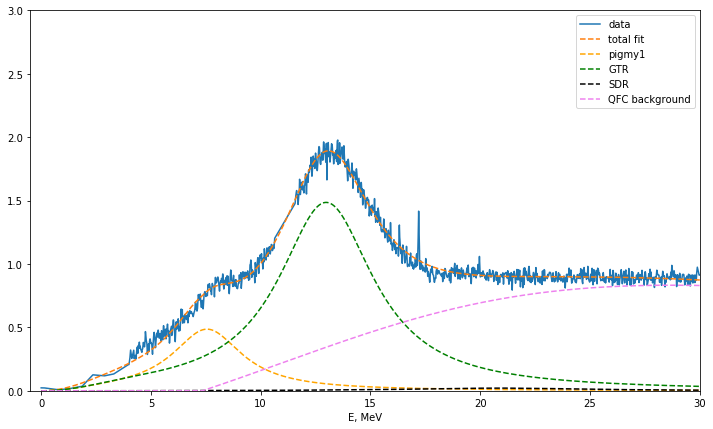

In [30]:
i = 0
plt.figure(figsize=(12,7))
y_fit = total_dataset(result.params, i, data_to_fit_x)

#plt.plot(red_0_4['x'].values, red_0_4['y'].values, c="silver")
#plt.plot(red_full['x'].values, red_full['y'].values,)
plt.plot(data_to_fit_x, data_to_fit_y_noIAS[i, :], '-', label='data')
plt.plot(data_to_fit_x, y_fit, '--', label='total fit')

#PR1, IAS1, GTR, SDR, QFC = total_dataset_for_plot(result.params, i, data_to_fit_x)
PR1, GTR, SDR, QFC = total_dataset_for_plot(result.params, i, data_to_fit_x)

plt.plot(data_to_fit_x, PR1, 'orange', label='pigmy1', ls='--')
plt.plot(data_to_fit_x, GTR, 'g--', label='GTR')
plt.plot(data_to_fit_x, SDR, 'black', label='SDR', ls='--')
#plt.plot(data_to_fit_x, IAS1, 'b--', label='IAS')
plt.plot(data_to_fit_x, QFC, 'violet', label='QFC background', ls='--')
plt.xlabel('E, MeV')
#plt.ylabel('S(E), 1/MeV')
plt.ylim(0,3)
plt.xlim(-0.5,30)
plt.legend()
plt.show()

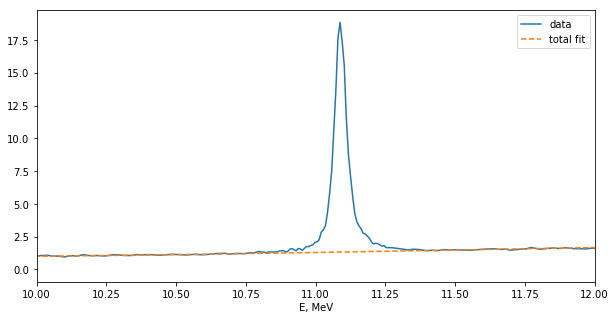

In [31]:
i = 0
plt.figure(figsize=(10,5))
y_fit = total_dataset(result.params, i, data_to_fit_x)
plt.plot(data_to_fit_x, data_to_fit_y[i, :], '-', label='data')
plt.plot(data_to_fit_x, y_fit, '--', label='total fit')

#PR1, IAS1, GTR, SDR, QFC = total_dataset_for_plot(result.params, i, data_to_fit_x)

#plt.plot(data_to_fit_x, IAS1, 'b--', label='IAS 76Ge')

plt.xlabel('E, MeV')
#plt.ylabel('S(E), 1/MeV')
#plt.ylim(0,20)
plt.xlim(10,12)
plt.legend()
plt.show()

In [32]:
#output = pd.DataFrame(data={'Ex, MeV':x_temp, 'S(E), Counts': y_temp})
#output.head()
PR1, IAS1, GTR, SDR, QFC = total_dataset_for_plot(result.params, 0, data_to_fit_x)
output = pd.DataFrame(data={'Ex, MeV':data_to_fit_x,
                            'PR+GTR':PR1+GTR,
                            'IAS':IAS1})
output.head()

ValueError: not enough values to unpack (expected 5, got 4)

In [ ]:
#output.to_excel('Mo100_BW_1PR_decomp.xls', index=False)

In [ ]:
def border_func2(x_data, y_data, border_l, border_r):
    a=np.where(x_data<border_r)
    b=np.where(x_data>border_l)
    temp_y = np.hstack(( y_data[a], np.zeros(len(x_data)-len(a[0])) ))
    #print(len(a[0]), len(x_data)-len(a[0]), len(x_data), a[0])
    return np.hstack((np.zeros((b[0][0])), temp_y[b]))

In [ ]:
PR1, GTR, SDR, QFC = total_dataset_for_plot(result.params, 0, data_to_fit_x)

BWfit_3_35 = trapz(border_func2(data_to_fit_x, PR1+GTR, 3, 3.5), data_to_fit_x)
BWfit_35_4 = trapz(border_func2(data_to_fit_x, PR1+GTR, 3.5, 4), data_to_fit_x)

bin_3_35/bin_35_4, BWfit_3_35/BWfit_35_4

In [ ]:
bin_3_35/BWfit_3_35, bin_35_4/BWfit_35_4, (bin_3_35+bin_35_4)/(BWfit_3_35+BWfit_35_4)

In [ ]:
k_BW = (bin_3_35+bin_35_4)/(BWfit_3_35+BWfit_35_4)

GT_summ_BW = trapz(PR1+GTR, data_to_fit_x)*k_BW
GT_summ_BW + 0.6, trapz(PR1+GTR, data_to_fit_x), (GT_summ_BW + 0.6)/total_GT

$R^2=\frac{d\sigma^{q=0}_{GT}}{d\sigma^{q=0}_{F}}*\frac{B(F)}{B(GT)}$  
т.к. B(GT)/B(F) = 3 то $3R^2=\frac{d\sigma^{q=0}_{GT}}{d\sigma^{q=0}_{F}}$. 

In [33]:
#Area_GT_BW = trapz(PR1+GTR, data_to_fit_x)
#Area_IAS_BW = trapz(IAS1, data_to_fit_x)


#Area_GT_BW/Area_IAS_BW, 3*R_square, 3*R_square*Area_IAS_BW 

In [34]:
#trapz(PR1+GTR, data_to_fit_x)/trapz(IAS1, data_to_fit_x), trapz(IAS1, data_to_fit_x), (total_IAS)/trapz(IAS1, data_to_fit_x) 

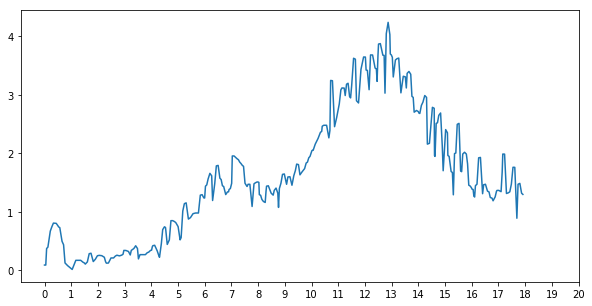

In [35]:
data1985 = pd.read_csv('../B(GT) peaks processing/recognition/Mo98/bgt 1985.csv', 
                      sep=';', decimal=',', names=['x', 'y'])
#data1985['x'] = -data1985['x'] + 120

plt.figure(figsize=(10,5))
plt.plot(data1985['x'].values, data1985['y'].values)
plt.xticks(np.arange(0,21,1))
plt.show()

In [36]:
trapz(data1985['y'].values, data1985['x'].values)

28.761363403147545

ValueError: not enough values to unpack (expected 5, got 4)

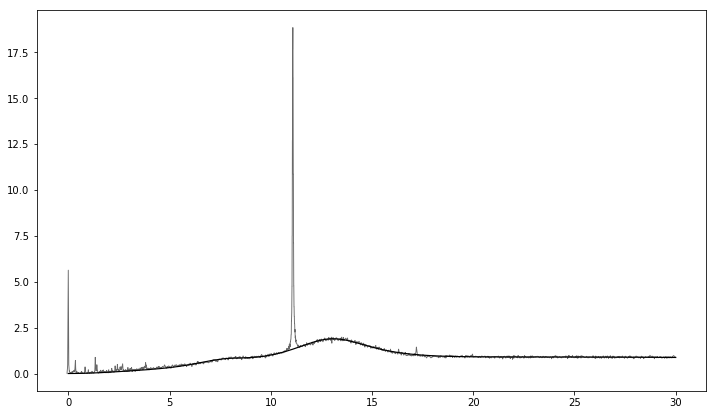

In [37]:
i = 0

f, ax = plt.subplots(figsize=(12,7))

y_fit = total_dataset(result.params, i, data_to_fit_x)
ax.plot(red_full['x'].values, red_full['y'].values, 'dimgrey', linewidth=0.9)
#plt.plot(data_to_fit_x, data_to_fit_y[i, :], '-', label='data')
ax.plot(data_to_fit_x, y_fit, 'k', ls='-', linewidth=1.2, label='total fit')

PR1, IAS1, GTR, SDR, QFC = total_dataset_for_plot(result.params, i, data_to_fit_x)

ax.plot(data_to_fit_x, PR1, 'k', label='pigmy1', ls='--', linewidth=0.8)
ax.plot(data_to_fit_x, GTR, 'k', label='GTR', ls='--', linewidth=0.8)
ax.plot(data_to_fit_x, SDR, 'k', label='SDR', ls='--', linewidth=0.8)
ax.plot(data_to_fit_x, IAS1, 'k', label='IAS', ls='--', linewidth=0.8)
ax.plot(data_to_fit_x, QFC, 'k', label='QFC background', ls='--', linewidth=0.8)

ax.text(12.7, 1.6, 'ГТР',  fontsize=14)
ax.text(21.3, 0.62, 'QFC',  fontsize=14)
ax.text(21.3, 0.25, 'SDR',  fontsize=14)
ax.text(10.2, 2.3, 'АР',  fontsize=14, rotation=0)
ax.text(7.3, 0.5, 'ПР1',  fontsize=14)

ax.set_ylabel('      Отн. ед.', x=0, y=1.02, rotation=0, fontsize=14)
ax.set_xlabel('$E$, МэВ', x=0.95, y=-0.15, fontsize=14)
ax.set_xticks(np.arange(0,32,2))

ax.tick_params(direction='in', labelsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#plt.ylabel('S(E), 1/MeV')
ax.set_ylim(0,3)
ax.set_xlim(-0.5,22)
#plt.legend()
plt.tight_layout()

#plt.savefig("Mo100_decomposition.png", format='png', transparent=False, dpi=500)

plt.show()

In [38]:
y_angleRED = np.interp(data_to_fit_x, red_full['x'].values, red_full['y'].values)

PR1, IAS1, GTR, SDR, QFC = total_dataset_for_plot(result.params, 0, data_to_fit_x)
#data_no_SDR_QFC = y_angleRED - SDR - QFC - IAS1
data_no_SDR_QFC = pd.DataFrame(data={'x':data_to_fit_x, 'y':y_angleRED-SDR-QFC-IAS1})
begining = data_no_SDR_QFC[data_no_SDR_QFC['x']<10.75]
ending = data_no_SDR_QFC[data_no_SDR_QFC['x']>11.5]
data_no_SDR_QFC_IAS = begining.append(ending)
data_no_SDR_QFC_IAS.head()

ValueError: not enough values to unpack (expected 5, got 4)

ValueError: not enough values to unpack (expected 5, got 4)

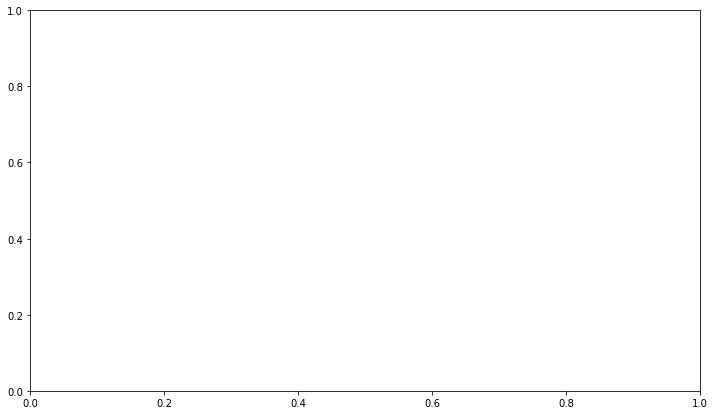

In [39]:
f, ax = plt.subplots(figsize=(12,7))

PR1, IAS1, GTR, SDR, QFC = total_dataset_for_plot(result.params, 0, data_to_fit_x)
PR1_GTR = PR1 + GTR 

y_PR_GTR = np.interp(np.arange(0,30,0.1), data_no_SDR_QFC_IAS['x'].values, data_no_SDR_QFC_IAS['y'].values)

temp_red_full = red_full[red_full["x"]<0.5]
ax.plot(temp_red_full['x'].values, temp_red_full['y'].values*k_BW, 'dimgrey', linewidth=0.9)
#ax.plot(red_full['x'].values, red_full['y'].values, 'dimgrey', linewidth=0.9)
ax.plot(data_to_fit_x, PR1_GTR*k_BW, 'k', ls='-', linewidth=1.2, label="Mo100")
#ax.plot(data_no_SDR_QFC_IAS['x'].values, data_no_SDR_QFC_IAS['y'].values*k_BW, 'dimgrey', linewidth=0.9, label="Mo100")

ax.plot(data1985['x'].values, data1985['y'].values, ls="--", label="Mo98")

#ax.step(np.arange(0,30,0.1), y_PR_GTR, where='mid', color='dimgrey', linewidth=0.9)

ax.plot(data_to_fit_x, PR1*k_BW, 'k', ls='--', linewidth=0.8)
ax.plot(data_to_fit_x, GTR*k_BW, 'k', ls='--', linewidth=0.8)

ax.text(12.7, 2.87, 'ГТР',  fontsize=14)
ax.text(7.3, 0.99, 'ПР1',  fontsize=14)

ax.set_ylabel('            $S(E)$', x=0, y=1.02, rotation=0, fontsize=14)
ax.set_xlabel('$E$, МэВ', x=0.95, y=-0.15, fontsize=14)
ax.set_xticks(np.arange(0,32,2))

ax.tick_params(direction='in', labelsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#plt.ylabel('S(E), 1/MeV')
ax.set_ylim(0,4)
ax.set_xlim(-0.5,18)
plt.legend()
plt.tight_layout()
plt.show()

### try to fit with gauss

In [40]:
fit_params_gauss = Parameters()
for iy, y in enumerate(data_to_fit_y):
    fit_params_gauss.add( 'PR1_mu_%i' % (iy+1), value=8, min=7.5, max=9)
    fit_params_gauss.add( 'PR1_sigma_%i' % (iy+1), value=0.1, min=0.01, max=5)
    fit_params_gauss.add( 'PR1_k_%i' % (iy+1), value=0.5, min=0.01, max= 20)
    
#    fit_params_gauss.add( 'IAS1_mu_%i' % (iy+1), value=11.085, vary=False)#
#    fit_params_gauss.add( 'IAS1_mu_%i' % (iy+1), value=11.085, min=11, max=11.2)
#    fit_params_gauss.add( 'IAS1_sigma_%i' % (iy+1), value=0.01, min=0.01, max=5)
#    fit_params_gauss.add( 'IAS1_k_%i' % (iy+1), value=0.5, min=0.05, max=20)

    fit_params_gauss.add( 'GTR_mu_%i' % (iy+1), value=13.0, min=12, max=14)
    fit_params_gauss.add( 'GTR_sigma_%i' % (iy+1), value=2, min=0.01, max=5)
    fit_params_gauss.add( 'GTR_k_%i' % (iy+1), value=0.5, min=0.01, max= 20)
    
    fit_params_gauss.add( 'SDR_mu_%i' % (iy+1), value=21, min=20, max=22)
    fit_params_gauss.add( 'SDR_sigma_%i' % (iy+1), value=0.01, min=0.01, max=7)
    fit_params_gauss.add( 'SDR_k_%i' % (iy+1), value=0.1, min=0.01, max= 0.7)
    
    fit_params_gauss.add( 'QFC_Eqf_%i' % (iy+1), value=400, max=410, min=385 )
    fit_params_gauss.add( 'QFC_N0_%i' % (iy+1), value=8, max=15, min=1 )
    
# but now constrain all values of sigma to have the same value
# by assigning sig_2, sig_3, .. sig_5 to be equal to sig_1
#fit_params['GTR_74_M_1'].expr='GTR_M_1 / 7'
#fit_params['GTR_74_G1_1'].expr='GTR_G1_1 * 0.9'
#fit_params['GTR_74_M_3'].expr='GTR_M_3 / 7'


#fit_params_gauss['SDR_mu_1'].expr='SDR_mu_2'


In [41]:
result_gauss = minimize(objective_gauss, fit_params_gauss, args=(data_to_fit_x, data_to_fit_y_noIAS), 
                  method='differential_evolution')

In [42]:
print(fit_report(result_gauss))

[[Fit Statistics]]
    # fitting method   = differential_evolution
    # function evals   = 35964
    # data points      = 4000
    # variables        = 11
    chi-square         = 8.00442066
    reduced chi-square = 0.00200662
    Akaike info crit   = -24834.2227
    Bayesian info crit = -24764.9881
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this.  Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    PR1_mu_1:     7.65547661 (init = 8)
    PR1_sigma_1:  2.45730261 (init = 0.1)
    PR1_k_1:      1.66244541 (init = 0.5)
    GTR_mu_1:     13.1973095 (init = 13)
    GTR_sigma_1:  2.05763127 (init = 2)
    GTR_k_1:      2.77350985 (init = 0.5)
    SDR_mu_1:     20.0000000 (init = 21)
    SDR_sigma_1:  2.33117664 (init = 0.01)
    SDR_k_1:      0.31523098 (init = 0.1)
    QFC_Eqf_1:    409.999997 (in

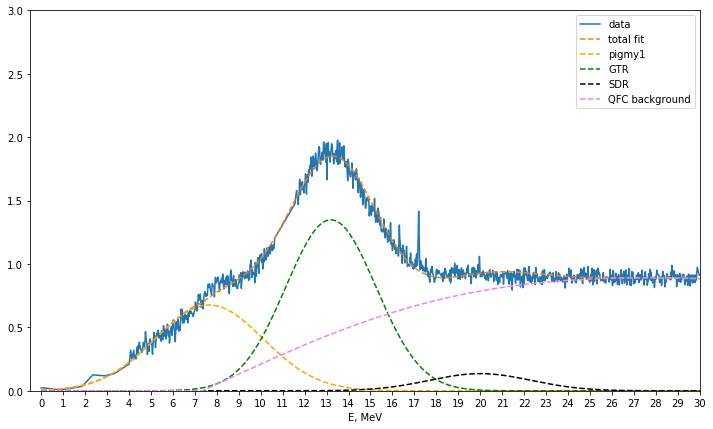

In [43]:
i = 0
plt.figure(figsize=(12,7))
y_fit = total_dataset_gauss(result_gauss.params, i, data_to_fit_x)
#plt.plot(red_full['x'].values, red_full['y'].values)
plt.plot(data_to_fit_x, data_to_fit_y_noIAS[i, :], '-', label='data')
plt.plot(data_to_fit_x, y_fit, '--', label='total fit')

#PR1, IAS1, GTR, SDR, QFC = total_dataset_for_plot_gauss(result_gauss.params, i, data_to_fit_x)
PR1, GTR, SDR, QFC = total_dataset_for_plot_gauss(result_gauss.params, i, data_to_fit_x)

plt.plot(data_to_fit_x, PR1, 'orange', label='pigmy1', ls='--')
plt.plot(data_to_fit_x, GTR, 'g--', label='GTR')
plt.plot(data_to_fit_x, SDR, 'black', label='SDR', ls='--')
#plt.plot(data_to_fit_x, IAS1, 'b--', label='IAS')
plt.plot(data_to_fit_x, QFC, 'violet', label='QFC background', ls='--')
plt.xlabel('E, MeV')
#plt.ylabel('S(E), 1/MeV')
plt.xticks(np.arange(0,32,1))
plt.ylim(0,3)
plt.xlim(-0.5,30)
plt.legend()
plt.show()

ValueError: not enough values to unpack (expected 5, got 4)

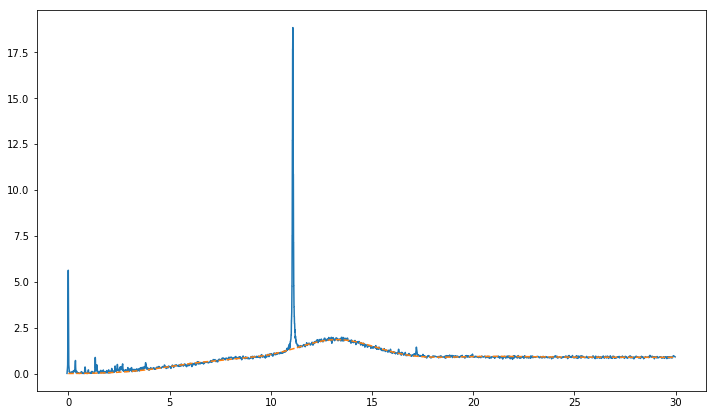

In [44]:
i = 0
plt.figure(figsize=(12,7))
y_fit = total_dataset_gauss(result_gauss.params, i, data_to_fit_x)
plt.plot(red_full['x'].values, red_full['y'].values)
#plt.plot(data_to_fit_x, data_to_fit_y[i, :], '-', label='data')
plt.plot(data_to_fit_x, y_fit, '--', label='total fit')

PR1, IAS1, GTR, SDR, QFC = total_dataset_for_plot_gauss(result_gauss.params, i, data_to_fit_x)

plt.plot(data_to_fit_x, PR1, 'orange', label='pigmy1', ls='--')
plt.plot(data_to_fit_x, GTR, 'g--', label='GTR')
plt.plot(data_to_fit_x, SDR, 'black', label='SDR', ls='--')
plt.plot(data_to_fit_x, IAS1, 'b--', label='IAS')
plt.plot(data_to_fit_x, QFC, 'violet', label='QFC background', ls='--')
plt.xlabel('E, MeV')
#plt.ylabel('S(E), 1/MeV')
#plt.xticks(np.arange(0,32,1))
#plt.ylim(0,3)
plt.xlim(10,12)
plt.legend()
plt.show()

In [45]:
PR1, GTR, SDR, QFC = total_dataset_for_plot_gauss(result_gauss.params, i, data_to_fit_x)

Gfit_3_35 = trapz(border_func2(data_to_fit_x, PR1+GTR, 3, 3.5), data_to_fit_x)
Gfit_35_4 = trapz(border_func2(data_to_fit_x, PR1+GTR, 3.5, 4), data_to_fit_x)

bin_3_35/bin_35_4, Gfit_3_35/Gfit_35_4

NameError: name 'border_func2' is not defined

In [46]:
bin_3_35/Gfit_3_35, bin_35_4/Gfit_35_4, (bin_3_35+bin_35_4)/(Gfit_3_35+Gfit_35_4)

NameError: name 'Gfit_3_35' is not defined

In [47]:
k_G = (bin_3_35+bin_35_4)/(Gfit_3_35+Gfit_35_4)

GT_summ_G = trapz(PR1+GTR, data_to_fit_x)*k_G
GT_summ_G+0.6, trapz(PR1+GTR, data_to_fit_x), (GT_summ_G+0.6)/total_GT

NameError: name 'Gfit_3_35' is not defined

In [48]:
Area_GT_G = trapz(PR1+GTR, data_to_fit_x)
Area_IAS_G = trapz(IAS1, data_to_fit_x)


Area_GT_G/Area_IAS_G, 3*R_square, 3*R_square*Area_IAS_G

NameError: name 'IAS1' is not defined

In [49]:
trapz(PR1+GTR, data_to_fit_x)/trapz(IAS1, data_to_fit_x), trapz(IAS1, data_to_fit_x), (total_IAS)/trapz(IAS1, data_to_fit_x) 

NameError: name 'IAS1' is not defined

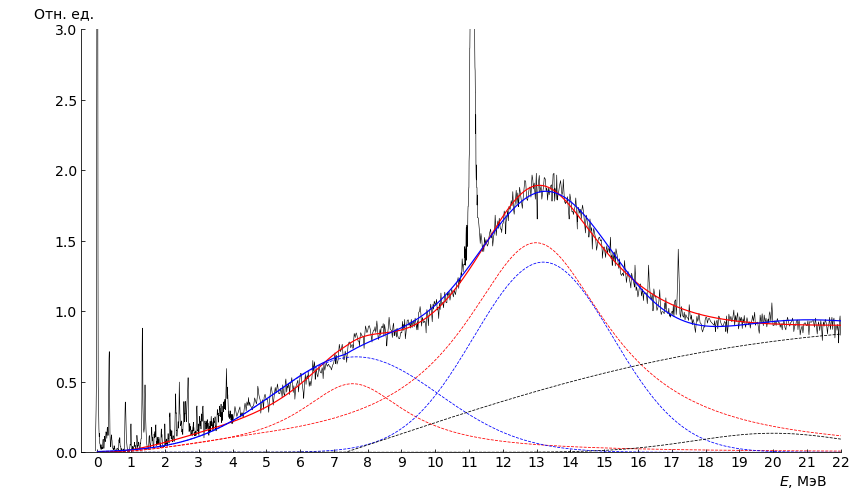

In [50]:
i = 0

f, ax = plt.subplots(figsize=(12,7))

y_fit_BW = total_dataset(result.params, i, data_to_fit_x)
y_fit_G = total_dataset_gauss(result_gauss.params, i, data_to_fit_x)
#ax.plot(red_full['x'].values, red_full['y'].values, 'dimgrey', linewidth=0.9)
ax.plot(red_full['x'].values, red_full['y'].values, 'k', linewidth=0.6)
#plt.plot(data_to_fit_x, data_to_fit_y[i, :], '-', label='data')
ax.plot(data_to_fit_x, y_fit_BW, 'red', ls='-', linewidth=1.2, label='total fit')
ax.plot(data_to_fit_x, y_fit_G, 'blue', ls='-', linewidth=1.2, label='total fit')

#PR1, IAS1, GTR, SDR, QFC = total_dataset_for_plot(result.params, i, data_to_fit_x)

PR1_BW, GTR_BW, SDR_BW, QFC_BW = total_dataset_for_plot(result.params, 0, data_to_fit_x)
PR1_GTR_BW = PR1_BW + GTR_BW 

PR1_G, GTR_G, SDR_G, QFC_G = total_dataset_for_plot_gauss(result_gauss.params, 0, data_to_fit_x)
PR1_GTR_G = PR1_G + GTR_G 

ax.plot(data_to_fit_x, PR1_BW, 'red', label='pigmy1 BW', ls='--', linewidth=0.8)
ax.plot(data_to_fit_x, PR1_G, 'blue', label='pigmy1 G', ls='--', linewidth=0.8)
ax.plot(data_to_fit_x, GTR_BW, 'red', label='GTR BW', ls='--', linewidth=0.8)
ax.plot(data_to_fit_x, GTR_G, 'blue', label='GTR G', ls='--', linewidth=0.8)
ax.plot(data_to_fit_x, SDR_G, 'k', label='SDR', ls='--', linewidth=0.8)
#ax.plot(data_to_fit_x, IAS1, 'k', label='IAS', ls='--', linewidth=0.8)
ax.plot(data_to_fit_x, QFC_G, 'k', label='QFC background', ls='--', linewidth=0.8)

#ax.text(12.7, 1.6, 'ГТР',  fontsize=14)
#ax.text(21.3, 0.62, 'QFC',  fontsize=14)
#ax.text(21.3, 0.25, 'SDR',  fontsize=14)
#ax.text(10.2, 2.3, 'АР',  fontsize=14, rotation=0)
#ax.text(7.3, 0.5, 'ПР1',  fontsize=14)

ax.set_ylabel('      Отн. ед.', x=0, y=1.02, rotation=0, fontsize=14)
ax.set_xlabel('$E$, МэВ', x=0.95, y=-0.15, fontsize=14)
ax.set_xticks(np.arange(0,32,1))

ax.tick_params(direction='in', labelsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#plt.ylabel('S(E), 1/MeV')
ax.set_ylim(0,3)
ax.set_xlim(-0.5,22)
#plt.legend()
plt.tight_layout()

#plt.savefig("Mo100_decomposition.png", format='png', transparent=False, dpi=500)

plt.show()

ValueError: not enough values to unpack (expected 5, got 4)

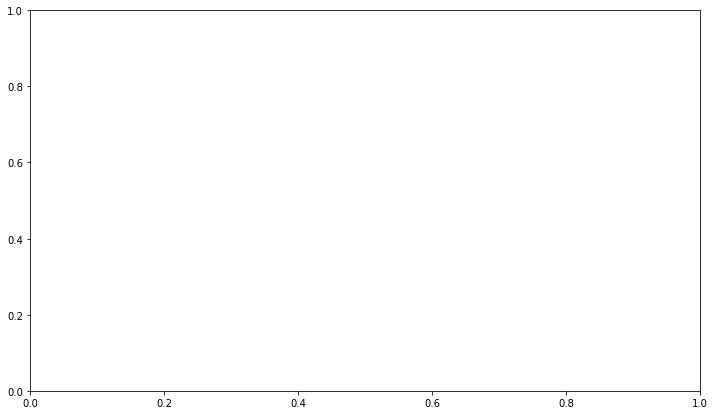

In [51]:
f, ax = plt.subplots(figsize=(12,7))

PR1_BW, _, GTR_BW, _, _ = total_dataset_for_plot(result.params, 0, data_to_fit_x)
PR1_GTR_BW = PR1_BW + GTR_BW 

PR1_G, _, GTR_G, _, _ = total_dataset_for_plot_gauss(result_gauss.params, 0, data_to_fit_x)
PR1_GTR_G = PR1_G + GTR_G 

y_PR_GTR = np.interp(np.arange(0,30,0.1), data_no_SDR_QFC_IAS['x'].values, data_no_SDR_QFC_IAS['y'].values)

temp_red_full = red_full[red_full["x"]<0.5]
ax.plot(temp_red_full['x'].values, temp_red_full['y'].values*k_BW, 'dimgrey', linewidth=0.9)
#ax.plot(red_full['x'].values, red_full['y'].values, 'dimgrey', linewidth=0.9)
ax.plot(data_to_fit_x, PR1_GTR_BW*k_BW, 'k', ls='-', linewidth=1.2, label="Mo100 (B-W)")
ax.plot(data_to_fit_x, PR1_GTR_G*k_G, 'm', ls='-', linewidth=1.2, label="Mo100 (Gauss)")
#ax.plot(data_no_SDR_QFC_IAS['x'].values, data_no_SDR_QFC_IAS['y'].values*k_BW, 'dimgrey', linewidth=0.9, label="Mo100")

ax.plot(data1985['x'].values, data1985['y'].values, ls="--", label="Mo98")

#ax.step(np.arange(0,30,0.1), y_PR_GTR, where='mid', color='dimgrey', linewidth=0.9)

#ax.plot(data_to_fit_x, PR1_BW*k_BW, 'k', ls='--', linewidth=0.8)
#ax.plot(data_to_fit_x, GTR_BW*k_BW, 'k', ls='--', linewidth=0.8)

#ax.plot(data_to_fit_x, PR1_G*k_G, 'k', ls=':', linewidth=0.8)
#ax.plot(data_to_fit_x, GTR_G*k_G, 'k', ls=':', linewidth=0.8)

#ax.text(12.7, 2.87, 'ГТР',  fontsize=14)
#ax.text(7.3, 0.99, 'ПР1',  fontsize=14)

ax.set_ylabel('            $S(E)$', x=0, y=1.02, rotation=0, fontsize=14)
ax.set_xlabel('$E$, МэВ', x=0.95, y=-0.15, fontsize=14)
ax.set_xticks(np.arange(0,32,2))

ax.tick_params(direction='in', labelsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#plt.ylabel('S(E), 1/MeV')
ax.set_ylim(0,4)
ax.set_xlim(-0.5,18)
plt.legend()
plt.tight_layout()
plt.show()

## gauss 2PR

In [52]:
fit_params_gauss_2PR = Parameters()
    
for iy, y in enumerate(data_to_fit_y):
    fit_params_gauss_2PR.add( 'PR1_mu_%i' % (iy+1), value=8, min=7.7, max=9)
    fit_params_gauss_2PR.add( 'PR1_sigma_%i' % (iy+1), value=0.1, min=0.01, max=2.5)
    fit_params_gauss_2PR.add( 'PR1_k_%i' % (iy+1), value=0.5, min=0.5, max=5)
    
    fit_params_gauss_2PR.add( 'PR2_mu_%i' % (iy+1), value=5, min=3, max=7)
    fit_params_gauss_2PR.add( 'PR2_sigma_%i' % (iy+1), value=0.1, min=0.01, max=1.0)
    fit_params_gauss_2PR.add( 'PR2_k_%i' % (iy+1), value=0.5, min=0.01, max= 0.5)
    
#    fit_params_gauss_2PR.add( 'PR2_mu_%i' % (iy+1), value=11.085, min=11, max=12)
#    fit_params_gauss_2PR.add( 'PR2_sigma_%i' % (iy+1), value=0.1, min=0.01, max=2.5)
#    fit_params_gauss_2PR.add( 'PR2_k_%i' % (iy+1), value=0.5, min=0.01, max= 3)
    
#    fit_params_gauss_2PR.add( 'IAS1_mu_%i' % (iy+1), value=11.085, vary=False)
#    fit_params_gauss_2PR.add( 'IAS1_sigma_%i' % (iy+1), value=0.01, min=0.01, max=5)
#    fit_params_gauss_2PR.add( 'IAS1_k_%i' % (iy+1), value=0.5, min=0.05, max=2)

    fit_params_gauss_2PR.add( 'GTR_mu_%i' % (iy+1), value=13.0, min=12, max=14)
    fit_params_gauss_2PR.add( 'GTR_sigma_%i' % (iy+1), value=2, min=0.01, max=5)
    fit_params_gauss_2PR.add( 'GTR_k_%i' % (iy+1), value=0.5, min=0.01, max= 20)
    
    fit_params_gauss_2PR.add( 'SDR_mu_%i' % (iy+1), value=21, min=20, max=22)
    fit_params_gauss_2PR.add( 'SDR_sigma_%i' % (iy+1), value=0.01, min=0.01, max=7)
    fit_params_gauss_2PR.add( 'SDR_k_%i' % (iy+1), value=0.5, min=0.01, max= 2)
    
    fit_params_gauss_2PR.add( 'QFC_Eqf_%i' % (iy+1), value=400, max=410, min=385 )
    fit_params_gauss_2PR.add( 'QFC_N0_%i' % (iy+1), value=8, max=15, min=1 )
    
# but now constrain all values of sigma to have the same value
# by assigning sig_2, sig_3, .. sig_5 to be equal to sig_1
#fit_params['GTR_74_M_1'].expr='GTR_M_1 / 7'
#fit_params['GTR_74_G1_1'].expr='GTR_G1_1 * 0.9'
#fit_params['GTR_74_M_3'].expr='GTR_M_3 / 7'


#fit_params_gauss_2PR['SDR_mu_1'].expr='SDR_mu_2'


In [53]:
result_gauss_2PR = minimize(objective2PR_gauss, fit_params_gauss_2PR, args=(data_to_fit_x, data_to_fit_y_noIAS), 
                  method='COBYLA')

In [54]:
print(fit_report(result_gauss_2PR))

[[Fit Statistics]]
    # fitting method   = COBYLA
    # function evals   = 15000
    # data points      = 4000
    # variables        = 14
    chi-square         = 8.03281525
    reduced chi-square = 0.00201526
    Akaike info crit   = -24814.0583
    Bayesian info crit = -24725.9416
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this.  Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    PR1_mu_1:     7.71757589 (init = 8)
    PR1_sigma_1:  1.65731969 (init = 0.1)
    PR1_k_1:      1.13409622 (init = 0.5)
    PR2_mu_1:     4.48100571 (init = 5)
    PR2_sigma_1:  0.93999815 (init = 0.1)
    PR2_k_1:      0.22195822 (init = 0.5)
    GTR_mu_1:     13.0065490 (init = 13)
    GTR_sigma_1:  2.18274293 (init = 2)
    GTR_k_1:      3.07382829 (init = 0.5)
    SDR_mu_1:     20.4975445 (init = 21)
    SDR_s

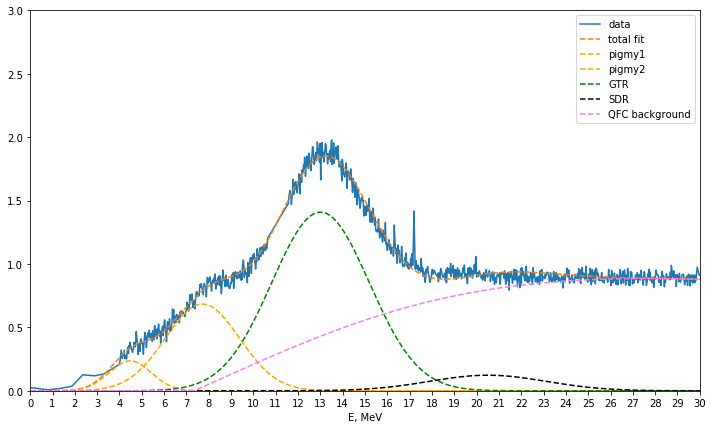

In [55]:
i = 0
plt.figure(figsize=(12,7))
y_fit = total_dataset2PR_gauss(result_gauss_2PR.params, i, data_to_fit_x)
#plt.plot(red_full['x'].values, red_full['y'].values)
plt.plot(data_to_fit_x, data_to_fit_y_noIAS[i, :], '-', label='data')
plt.plot(data_to_fit_x, y_fit, '--', label='total fit')

#PR1, PR2, IAS1, GTR, SDR, QFC = total_dataset_for_plot2PR_gauss(result_gauss_2PR.params, i, data_to_fit_x)
PR1, PR2, GTR, SDR, QFC = total_dataset_for_plot2PR_gauss(result_gauss_2PR.params, i, data_to_fit_x)

plt.plot(data_to_fit_x, PR1, 'orange', label='pigmy1', ls='--')
plt.plot(data_to_fit_x, PR2, 'orange', label='pigmy2', ls='--')
plt.plot(data_to_fit_x, GTR, 'g--', label='GTR')
plt.plot(data_to_fit_x, SDR, 'black', label='SDR', ls='--')
#plt.plot(data_to_fit_x, IAS1, 'b--', label='IAS')
plt.plot(data_to_fit_x, QFC, 'violet', label='QFC background', ls='--')
plt.xlabel('E, MeV')
#plt.ylabel('S(E), 1/MeV')
plt.xticks(np.arange(0,32,1))
plt.ylim(0,3)
plt.xlim(0,30)
plt.legend()
plt.show()

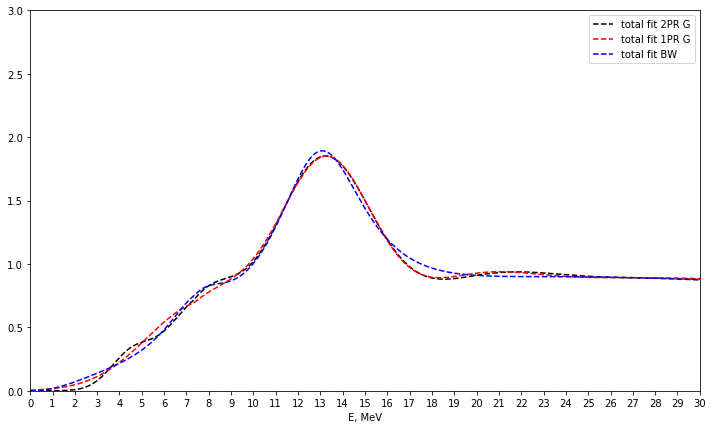

In [56]:
i = 0
plt.figure(figsize=(12,7))
y_fit_2PR_G = total_dataset2PR_gauss(result_gauss_2PR.params, i, data_to_fit_x)
y_fit_1PR_G = total_dataset_gauss(result_gauss.params, i, data_to_fit_x)
y_fit_BW = total_dataset(result.params, i, data_to_fit_x)
#plt.plot(red_full['x'].values, red_full['y'].values)
#plt.plot(data_to_fit_x, data_to_fit_y[i, :], '-', label='data')
plt.plot(data_to_fit_x, y_fit_2PR_G, '--', c='k', label='total fit 2PR G')
plt.plot(data_to_fit_x, y_fit_1PR_G, '--', c='red', label='total fit 1PR G')
plt.plot(data_to_fit_x, y_fit_BW, '--', c='blue', label='total fit BW')

plt.xlabel('E, MeV')
#plt.ylabel('S(E), 1/MeV')
plt.xticks(np.arange(0,32,1))
plt.ylim(0,3)
plt.xlim(0,30)
plt.legend()
plt.show()